[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Kalman Filter Math

In [12]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

** author's note:** *the ordering of material in this chapter is questionable. I delve into solving ODEs before discussing the basic Kalman equations. If you are reading this while it is being worked on (so long as this notice exists), you may find it easier to skip around a bit until I organize it better.*


If you've gotten this far I hope that you are thinking that the Kalman filter's fearsome reputation is somewhat undeserved. Sure, I hand waved some equations away, but I hope implementation has been fairly straightforward for you. The underlying concept is quite straightforward - take two measurements, or a measurement and a prediction, and choose the output to be somewhere between the two. If you believe the measurement more your guess will be closer to the measurement, and if you believe the prediction is more accurate your guess will lie closer it it. That's not rocket science (little joke - it is exactly this math that got Apollo to the moon and back!). 

Well, to be honest I have been choosing my problems carefully. For any arbitrary problem finding some of the matrices that we need to feed into the Kalman filter equations can be quite difficult. I haven't been *too tricky*, though. Equations like Newton's equations of motion can be trivially computed for Kalman filter applications, and they make up the bulk of the kind of problems that we want to solve. If you are a hobbyist, you can safely pass by this chapter for now, and perhaps forever. Some of the later chapters will assume the material in this chapter, but much of the work will still be accessible to you. 

But, I urge everyone to at least read the first section, and to skim the rest. It is not much harder than what you have done - the difficulty comes in finding closed form expressions for specific problems, not understanding the math in this chapter. 

## Bayesian Probability

The title of this book is *Kalman and Bayesian Filters in Python* but to date I have not touched on the Bayesian aspect much. There was enough going on in the earlier chapters that adding this form of reasoning about filters could be a distraction rather than a help. I now wish to take some time to explain what Bayesian probability is and how a Kalman filter is in fact a Bayesian filter. This is not just a diversion. First of all, a lot of the Kalman filter literature uses this formulation when talking about filters, so you will need to understand what they are talking about. Second, this math plays a strong role in filtering design once we move past the Kalman filter. 

To do so we will go back to our first tracking problem - tracking a dog in a hallway. Recall the update step - we believed with some degree of precision that the dog was at position 7 (for example), and then receive a measurement that the dog is at position 7.5. We want to incorporate that measurement into our belief. In the *Discrete Bayes* chapter we used histograms to denote our estimates at each hallway position, and in the *One Dimensional Kalman Filters* we used Gaussians. Both are method of using *Bayesian* probability.

Briefly, *Bayesian* probability is a branch of math that lets us evaluate a hypothesis or new data point given some uncertain information about the past. For example, suppose you are driving down your neighborhood street and see one of your neighbors at their door, using a key to let themselves in. Three doors down you see two people in masks breaking a window of another house. What might you conclude?

It is likely that you would reason that in the first case your neighbors were getting home and unlocking their door to get inside. In the second case you at least strongly suspect a robbery is in progress. In the first case you would just proceed on, and in the second case you'd probably call the police.

Of course, things are not always what they appear. Perhaps unbeknownst to you your neighbor sold their house that morning, and they were now breaking in to steal the new owner's belongings. In the second case, perhaps the owners of the house were at a costume event at the next house, they had a medical emergency with their child, realized they lost their keys, and were breaking into their own house to get the much needed medication. Those are both *unlikely* events, but possible. Adding a few additional pieces of information would allow you to determine the true state of affairs in all but the most complicated situations.

These are instances of *Bayesian* reasoning. We take knowledge from the past and integrate in new information. You know that your neighbor owned their house yesterday, so it is still highly likely that they still own it today. You know that owners of houses normally have keys to the front door, and that the normal mode of entrance into your own house is not breaking windows, so the second case is *likely* to be a breaking and entering. The reasoning is not ironclad as shown by the alternative explanations, but it is likely.

### Bayes' theorem

*Bayes' theorem* mathematically formalizes the above reasoning. It is written as

$$P(A|B) = \frac{P(B | A)\, P(A)}{P(B)}\cdot$$


Before we do some computations, let's review what the terms mean. P(A) is called the *prior probability* of the event A, and is often just shortened to the *prior*. What is the prior? It is just the probability of A being true *before* we incorporate new evidence. In our dog tracking problem above, the prior is the probability we assign to our belief that the dog is positioned at 7 before we make the measurement of 7.5. It is important to master this terminology if you expect to read a lot of the literature.

$P(A|B)$ is the *conditional probability* that A is true given that B is true. For example, if it is true that your neighbor still owns their house, then it will be very likely that they are not breaking into their house. In Bayesian probability this is called the *posterior*, and it denotes our new belief after incorporating the measurement/knowledge of B. For our dog tracking problem the posterior is the probability given to the estimated position after incorporating the measurement 7.5. For the neighbor problem the posterior would be the probability of a break in after you find out that your neighbor sold their home last week.

What math did we use for the dog tracking problem? Recall that we used this equation to compute the new mean and probability distribution

$$
\begin{aligned}
N(estimate) * N(measurement) &= \\
N(\mu_1, \sigma_1^2)*N(\mu_2, \sigma_2^2) &= N(\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1}{\sigma_1^2 + \sigma_2^2},\frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}) \cdot
\end{aligned}
$$ 


Here $N(\mu_1, \sigma_1^2)$ is the old estimated position, so $\sigma_1$ is an indication of our *prior* probability. $N(\mu_2, \sigma_2^2)$ is the mean and variance of our measurement, and so the result can be thought of as the new position and probability distribution after incorporating the new measurement. In other words, our *posterior distribution* is 

$$\frac{1}{{\sigma_{estimate}}^2} + \frac{1}{{\sigma_{measurement}}^2}$$

This is still a little hard to compare to Bayes' equation because we are dealing with probability distributions rather than probabilities. So let's cast our minds back to the discrete Bayes chapter where we computed the probability that our dog was at any given position in the hallway. It looked like this:

    def update(pos_belief, measure, p_hit, p_miss):
        for i in range(len(hallway)):
            if hallway[i] == measure:
                pos_belief[i] *= p_hit
            else:
                pos_belief[i] *= p_miss

        pos_belief /= sum(pos_belief)

Let's rewrite this using our newly learned terminology.

    def update(prior_probability, measure, prob_hit, prob_miss):
        posterior_probability = np.zeros(len(prior_probability))
        for i in range(len(hallway)):
            if hallway[i] == measure:
                posterior_probability[i] = prior_probability[i] * p_hit
            else:
                posterior_probability[i] = prior_probability[i] * p_miss

        return posterior_probability / sum(posterior_probability)

         
So what is this doing? It's multiplying the old belief that the dog is at position *i* (prior probability) with the probability that the measurement is correct for that position, and then dividing by the total probability for that new event.

Now let's look at Bayes' equation again.

$$P(A|B) = \frac{P(B | A)\, P(A)}{P(B)}\cdot$$

It's the same thing being calculated by the code. Multiply the prior ($P(A)$) by the probability of the measurement at each position ($P(B|A)$) and divide by the total probability for the event ($P(B)$).

In other words the first half of the Discrete Bayes chapter developed Bayes' equation from a thought experiment. I could have just presented Bayes' equation and then given you the Python routine above to implement it, but chances are you would not have understood *why* Bayes' equation works. Presenting the equation first is the normal approach of Kalman filtering texts, and I always found it extremely nonintuitive. 

## Computing Means and Covariances

You will not need to do this by hand for the rest of the book, but it is important to understand the computations behind these values. It only takes a few minutes to learn.

### Computing the Mean

So let's start with 3 variables: $a, b, c$. Let's say we have two values for each: $a = [1, 3]$, $b = [8, 7]$, and $c = [3,7]$. Another, equivalent way of writing this is that you will sometimes see is

$$\mathbf{x} = \begin{bmatrix}a\\b\\c\end{bmatrix} = \begin{bmatrix}1 & 3\\8&7\\3&7\end{bmatrix}$$

You will not see that often in the Kalman filter literature, so I will adopt the alternative notation of using a subscript to indicate the $i^{th}$ value for $\mathbf{x}$

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We compute the mean just as for the univariate case, which we presented in the *Gaussians* chapter. Sum the values and divide by the number of values. Formally

$$ \mu_x = \frac{1}{n}\sum^n_{i=1} x_i$$

Therefore we can write:

$$\begin{aligned}
\mu_a &= \frac{1+3}{2} = 2 \\
\mu_b &= \frac{8+7}{2} = 7.5 \\
\mu_c &= \frac{3+7}{2} = 5 
\end{aligned}$$

Which I can express in our shorthand matrix notation as

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

### Expected Value

I could just give you the formula for the covariance but it will make more sense if you see how it is derived. To do that we first need to talk about **expected value** of a random variable. The expected value is just the value we expect, on average, for the variable. 

The expected value of a random variable is just the average value it would have if we took an infinite number of samples of it and then averaged those samples together. Let's say we have $x=[1,3,5]$ and each value is equally probable. What would we *expect* $x$ to have, on average?

It would just be the average of 1, 3, and 5, of course, which is 3. That should make sense; we would expect equal numbers of 1, 3, and 5 to occur, so $(1+3+5)/3=3$ is clearly the average of that infinite series of samples.

Now suppose that each value has a different probability of happening. Say 1 has an 80% chance of occurring, 3 has an 15% chance, and 5 has only a 5% chance. In this case we compute the expected value by multiplying each value of $x$ by the percent chance of it occurring, and summing the result. So for this case we could compute

$$E[x] = (1)(0.8) + (3)(0.15) + (5)(0.05) = 1.5$$

Here I have introduced the standard notation $E[x]$ for the expected value of $x$.

We can formalize this by letting $x_i$ be the $i^{th}$ value of $x$, and $p_i$ be the probability of its occurrence. This gives us

$$E[X] = \sum_{i=1}^n p_ix_i$$

The value 1.5 for $x$ makes intuitive sense because x is far more like to be 1 than 3 or 5, and 3 is more likely than 5 as well.

It is probably worth me pointing out now that if $x$ is continuous we substitute the sum for an integral, like so

$$E[X] = \int_{-\infty}^\infty xf(x)$$

where $f(x)$ is the probability distribution function of $x$. We won't be using this equation yet, but we will be using it in the next chapter.

### Computing the Covariance


Now we are prepared to compute the covariance matrix. The **covariance** measures how much two random variables move in the same direction, and is defined as

$$ COV(x,y) = \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y)$$

If we compare this to the formula for the variance of a single variable we can see where this definition came from.

$$\sigma^2 = \frac{1}{N}\sum_{i=1}^N(x_i - \mu)^2$$

And indeed, the covariance of a variable with itself is just the variance of the variable, which we can trivially prove with

$$\begin{aligned}
COV(x,x) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(x_i - \mu_x) \\
&= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)^2 \\
&= VAR(x)
\end{aligned}$$


Let's build some familiarity with this by calculating the covariance for the $\mathbf{x}$ from the beginning of this section.

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We already know the mean is

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

Recall that we named the three variables as $a, b, c$. Let's start by computing the variance of $a$.

$$
\begin{aligned}
VAR(a) &= \frac{1}{2}[(1-2)^2 + (3-2)^2] \\
&= \frac{1}{2}[1+1] \\
&= 1\end{aligned}$$


Using similar math we can compute that $VAR(a) = 0.25$ and $VAR(c)=4$. This allows us to fill in the covariance matrix with

$$\Sigma = \begin{bmatrix}1 & & \\ & 0.25 & \\ &&4\end{bmatrix}$$

Now we can compute the covariance of a and b.

$$
\begin{aligned}
COV(a,b) &= \frac{1}{2}[(1-2)(8-7.5) + (3-2)(7-7.5)] \\
&= \frac{1}{2}[(-1)(.5)+  (1)(-.5)] \\
&= -0.5\end{aligned}$$

We can fill in the $a^{th}$ row and $b^{th}$ column  in the covariance matrix with this value:

$$\Sigma = \begin{bmatrix}1 & & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$

We already talked about the symmetry of the covariance matrix; $\sigma_{ab}=\sigma_{ba}$. We see now why this is true from the equation for the covariance.

$$\begin{aligned} COV(x,y) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y) \\
&= \frac{1}{N}\sum_{i=1}^N (y_i - \mu_y)(x_i - \mu_x) \\
&= COV(y,x)\end{aligned}$$

This gives the covariance matrix

$$\Sigma = \begin{bmatrix}1 &-0.5 & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$.

The arithmetic is a bit tedious, so let's just use NumPy's `cov()` function to compute the entire covariance matrix. To compute the covariance in accordance with the equations above you will need to set the parameter `bias=1`.  The meaning of that parameter is not important to this book. If you are interested, wikipedia has a good article on it here http://en.wikipedia.org/wiki/Bias_of_an_estimator.

In [13]:
import numpy as np

x = [[1, 3], [8, 7], [3, 7]]
print(np.cov(x, bias=1))

[[ 1.   -0.5   2.  ]
 [-0.5   0.25 -1.  ]
 [ 2.   -1.    4.  ]]


We said above that "the *covariance* measures how much two random variables move in the same direction", so let's see what that means in practice. If we start with the value $x_0 = (1, 2)$ we can create subsequent values that vary in the same direction with $x_1 = (2, 4)$, $x_2=(3,6)$, and $x_3=(4,8)$.

[[ 1.25  2.5 ]
 [ 2.5   5.25]]


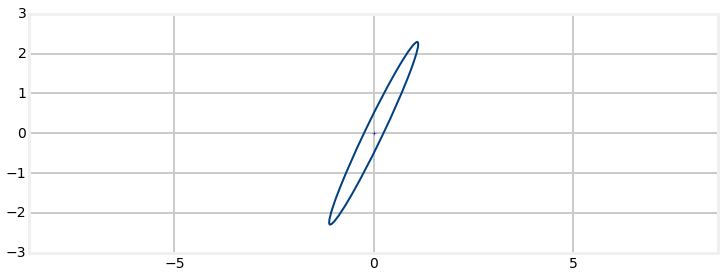

In [14]:
from filterpy.common import plot_covariance_ellipse

x = [[1, 2, 3, 4], [2, 3,5, 8]]
cov = np.cov(x, bias=1)
plot_covariance_ellipse([0, 0], cov)
print(cov)

The values for $x$ are perfectly correlated, and the result is a covariance ellipse with zero width. We can see this by making the values not slightly uncorrelated.

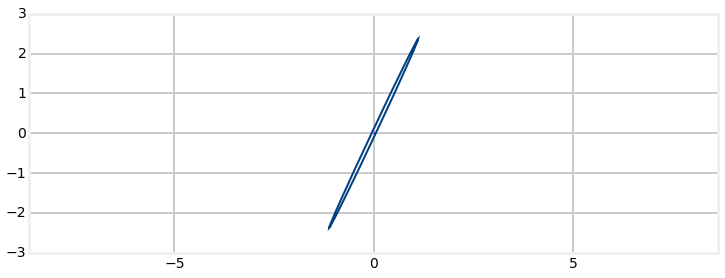

In [15]:
x = [[1, 2, 3, 4], [2, 4, 6, 8.4]]
plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

Now lets make the second value go away from the first.

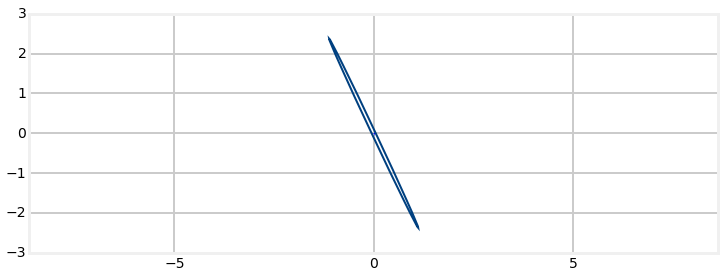

In [16]:
x = [[1, 2, 3, 4], [-2, -4, -6, -8.4]]
plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

As we would hope, the covariance matrix is tilted in the opposite direction, indicating that the variables are inversely correlated. That is, as one gets larger, the other becomes smaller.

## Modeling a Dynamic System that Has Noise

We need to start by understanding the underlying equations and assumptions that the Kalman filter uses. We are trying to model real world phenomena, so what do we have to consider?

First, each physical system has a process. For example, a car traveling at a certain velocity goes so far in a fixed amount of time, and its velocity varies as a function of its acceleration. We describe that behavior with the well known Newtonian equations we learned in high school.

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + d_0
\end{aligned}
$$

And once we learned calculus we saw them in this form:

$$
\begin{aligned}
 \mathbf{v} &= \frac{d \mathbf{x}}{d t}\\ 
 \quad \mathbf{a} &= \frac{d \mathbf{v}}{d t}\\
 &= \frac{d^2 \mathbf{x}}{d t^2} \,\!
\end{aligned}
 $$
 
A typical problem would have you compute the distance traveled given a constant velocity or acceleration. But, of course we know this is not all that is happening. First, we do not have perfect measures of things like the velocity and acceleration - there is always noise in the measurements, and we have to model that. Second, no car travels on a perfect road. There are bumps that cause the car to slow down, there is wind drag, there are hills that raise and lower the speed. If we do not have explicit knowledge of these factors we lump them all together under the term "process noise".

Trying to model all of those factors explicitly and exactly is impossible for anything but the most trivial problem. I could try to include equations for things like bumps in the road, the behavior of the car's suspension system, even the effects of hitting bugs with the windshield, but the job would never be done - there would always be more effects to add and limits to our knowledge (how many bugs do we hit in an hour, for example). What is worse, each of those models would in themselves be a simplification - do I assume the wind is constant, that the drag of the car is the same for all angles of the wind, that the suspension act as perfect springs, that the suspension for each wheel acts identically, and so on.

So control theory makes a mathematically correct simplification. We acknowledge that there are many factors that influence the system that we either do not know or that we don't want to have to model. At any time $t$ we say that the actual value (say, the position of our car) is the predicted value plus some unknown process noise:

$$
x(t) = x_{pred}(t) + noise(t)
$$

This is not meant to imply that $noise(t)$ is a function that we can derive analytically or that it is well behaved. If there is a bump in the road at $t=10$ then the noise factor will just incorporate that effect. Again, this is not implying that we model, compute, or even know the value of *noise(t)*, it is merely a statement of fact - we can *always* describe the actual value as the predicted value from our idealized model plus some other value. 

Let's express this with linear algebra. Using the same notation from previous chapters, we can say that our model of the system (without noise) is:

$$ f(\mathbf{x}) = \mathbf{Fx}$$

That is, we have a set of linear equations that describe our system. For our car, 
$\mathbf{F}$ will be the coefficients for Newton's equations of motion. 

Now we need to model the noise. We will just call that *w*, and add it to the equation.

$$ f(\mathbf{x}) = \mathbf{Fx} + \mathbf{w}$$

Finally, we need to consider inputs into the system. We are dealing with linear problems here, so we will assume that there is some input $u$ into the system, and that we have some linear model that defines how that input changes the system. For example, if you press down on the accelerator in your car the car will accelerate. We will need a matrix $\mathbf{B}$ to convert $u$ into the effect on the system. We just add that into our equation:

$$ f(\mathbf{x}) = \mathbf{Fx} + \mathbf{Bu} + \mathbf{w}$$

And that's it. That is one of the equations that Kalman set out to solve, and he found a way to compute an optimal solution if we assume certain properties of $w$.

However, we took advantage of something I left mostly unstated in the last chapter. We were able to provide a definition for $\mathbf{F}$ because we were able to take advantage of the exact solution that Newtonian equations provide us. However, if you have an engineering background you will realize what a small class of problems that covers. If you don't, I will explain it next, and provide you with several ways to compute $\mathbf{F}$ for arbitrary systems.

## Walking Through the Kalman Filter Equations

I promised that you would not have to understand how to derive Kalman filter equations, and that is true. However, I do think it is worth walking through the equations one by one and becoming familiar with the variables. If this is your first time through the material feel free to skip ahead to the next section. However, you will eventually want to work through this material, so why not now? You will need to have passing familiarity with these equations to read material written about the Kalman filter, as they all presuppose that you are familiar with them. I will reiterate them here for easy reference.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(3)\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

Just a reminder: the superscript $^-$ is used to denote that the value is a prediction, not an estimate. But $\mathbf{x}$ and $\mathbf{x}^-$ are the same thing, the *state* of our system, just at different times of the algorithm. I am not entirely pleased with this notation for several reasons. First, it clutters the equations up, making them harder to read. More importantly, that aren't always correct. For example, consider a situation wherre we have no measurement for 1 or more time periods. In that case we just compute the predict step several times in a row without an intervening update step. Thus, $\mathbf{x}$ is never computed, and the predict step is actually $\mathbf{x}^-_t = \mathbf{Fx}^-_{t-1} + \mathbf{Bu}$. Alternatively, if you have several measurements for one time epoch (from different sensors, say) it is possible to perform the update once for each measurement instead of trying to incorporate all of the measurements at once. Later in the book we will do this with a localization problem where we have bearing and distance measurements for several landmarks. In that case the subsequent updates are not performing the computations on the predicted state, but on the partially updated state. You can think of this as un update being performed with no movement or time having passed since the last update. The $^-$ notation does not capture any of these. For most of the book I will dispense with this notation unless I want to call out that I am computing a prediciton. 

I will start with the update step, as that is what we started with in the one dimensional Kalman filter case. The first equation is

$$
\mathbf{y} = \mathbf{z} - \mathbf{H x}\tag{3}
$$

On the right we have $\mathbf{Hx}$. That should be recognizable as the measurement function. Multiplying $\mathbf{H}$ with $\mathbf{x}$ puts $\mathbf{x}$ into *measurement space*; in other words, the same basis and units as the sensor's measurements. The variable $\mathbf{z}$ is just the measurement; it is typical, but not universal to use $\mathbf{z}$ to denote measurements in the literature ($\mathbf{y}$ is also sometimes used). Do you remember this chart?

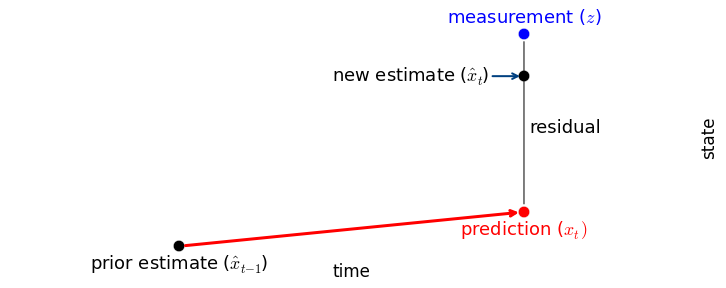

In [17]:
import mkf_internal
mkf_internal.show_residual_chart()

The blue point labeled "prediction" is the output of $\mathbf{Hx}$, and the dot labeled "measurement" is $\mathbf{z}$. Therefore, $\mathbf{y} = \mathbf{z} - \mathbf{Hx}$ is how we compute the residual, drawn in red, where $\mathbf{z}$ is the residual.

The next two lines are the formidable:

$$
\begin{aligned}
\textbf{S} &= \mathbf{HPH}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{PH}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\end{aligned}
$$

Unfortunately it is a fair amount of linear algebra to derive this. The derivation can be quite elegant, and I urge you to look it up if you have the mathematical education to follow it. But $\mathbf{K}$ is just the *Kalman gain* - the ratio of how much measurement vs prediction we should use to create the new estimate. $\mathbf{R}$ is the *measurement noise*, and $\mathbf{P}$ is our *uncertainty covariance matrix* from the prediction step.

So let's work through this expression by expression. Start with $\mathbf{HPH}^\mathsf{T}$. The linear equation $\mathbf{ABA}^T$ can be thought of as changing $\mathbf{B}$ to the coordinate system of $\mathbf{A}$. So $\mathbf{HPH}^\mathsf{T}$ is taking the covariance $\mathbf{P}$ and putting it in measurement ($\mathbf{H}$) space. 

In English, consider the problem of reading a temperature with a thermometer that provides readings in volts. Our state is in terms of temperature, but we are now doing calculations in *measurement space* - volts. So we need to convert $\mathbf{P}$ from applying to temperatures to volts. The linear algebra form $\textbf{H}\textbf{P}\textbf{H}^\mathsf{T}$ takes $\mathbf{P}$ to the basis used by $\mathbf{H}$, namely volts. 

Then, once in measurement space, we can add the measurement noise $\mathbf{R}$ to it. Hence, the expression for the uncertainty once we include the measurement is:

$$\mathbf{S} = \mathbf{HP}\mathbf{H}^\mathsf{T} + \mathbf{R}$$

The next equation is

$$\textbf{K} = \textbf{P}\textbf{H}^T\mathbf{S}^{-1}\\
$$

$\mathbf{K}$ is the *Kalman gain* - the ratio that chooses how far along the residual to select between the measurement and prediction in the graph above.

We can think of the inverse of a matrix as linear algebra's way of computing  $\frac{1}{x}$. So we can read the equation for $\textbf{K}$ as

$$ \textbf{K} = \frac{\textbf{P}\textbf{H}^\mathsf{T}}{\mathbf{S}} $$

$$
\textbf{K} = \frac{uncertainty_{prediction}}{uncertainty_{measurement}}\textbf{H}^\mathsf{T}
$$

In other words, the *Kalman gain* equation is doing nothing more than computing a ratio based on how much we trust the prediction vs the measurement. If we are confident in our measurements and unconfident in our predictions $\mathbf{K}$ will favor the measurement, and vice versa. The equation is complicated because we are doing this in multiple dimensions via matrices, but the concept is simple - scale by a ratio.

Without going into the derivation of $\mathbf{K}$, I'll say that this equation is the result of finding a value of $\mathbf{K}$ that optimizes the *mean-square estimation error*. It does this by finding the minimal values for $\mathbf{P}$ along its diagonal. Recall that the diagonal of $\mathbf{P}$ is just the variance for each state variable. So, this equation for $\mathbf{K}$ ensures that the Kalman filter output is optimal. To put this in concrete terms, for our dog tracking problem this means that the estimates for both position and velocity will be optimal - a value of $\mathbf{K}$ that made the position extremely accurate but the velocity very inaccurate would be rejected in favor of a $\mathbf{K}$ that made both position and velocity just somewhat accurate.

Our next line is:

$$\mathbf{x}=\mathbf{x} +\mathbf{Ky}\tag{5}$$

This just multiplies the residual by the Kalman gain, and adds it to the state variable. In other words, this is the computation of our new estimate.

Finally, we have:

$$\mathbf{P}=(\mathbf{I}-\mathbf{KH})\mathbf{P}\tag{6}$$

$I$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $H$ is our measurement function, and is a constant.  So, simplified, this is simply $P = (1-cK)P$. $K$ is our ratio of how much prediction vs measurement we use. So, if $K$ is large then $(1-cK)$ is small, and P will be made smaller than it was. If $K$ is small, then $(1-cK)$ is large, and P will be made larger than it was. So we adjust the size of our uncertainty by some factor of the *Kalman gain*. I would like to draw your attention back to the g-h filter, which included this Python code:

    # update filter 
    w = w * (1-scale_factor) + z * scale_factor

This multidimensional Kalman filter equation is partially implementing this calculation for the variance instead of the state variable.

Now we have the measurement steps. The first equation is

$$\mathbf{x} = \mathbf{Fx} + \mathbf{Bu}\tag{1}$$

This is just our state transition equation which we have already discussed. $\mathbf{Fx}$  multiplies $\mathbf{x}$ with the state transition matrix to compute the next state. $B$ and $u$ add in the contribution of the control input $\mathbf{u}$, if any.

The final equation is:
$$\mathbf{P} = \mathbf{FPF}^\mathsf{T} + \mathbf{Q}\tag{2}$$

$\mathbf{FPF}^\mathsf{T}$ is the way we put $\mathbf{P}$ into the process space using linear algebra so that we can add the process noise $\mathbf{Q}$ to it.

## Converting the Multivariate Equations to the Univariate Case


As it turns out the Kalman filter equations are quite easy to deal with in one dimension, so let's do the mathematical proof. 

> **Note:** This section will provide you with a strong intuition into what the Kalman filter equations are actually doing. While this section is not strictly required, I recommend reading this section carefully as it should make the rest of the material easier to understand. It is not merely a proof of correctness that you would normally want to skip past! The equations look complicated, but they are actually doing something quite simple.

Let's start with the predict step, which is slightly easier. Here are the multivariate equations.

$$
\begin{aligned}
\mathbf{x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{P} &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q}
\end{aligned}
$$

The state $\mathbf{x}$ only has one variable, so it is a $1\times 1$ matrix. Our motion $\mathbf{u}$ is also be a $1\times 1$ matrix. Therefore, $\mathbf{F}$ and $\mathbf{B}$ must also be $1\times 1$ matrices. That means that they are all scalars, and we can write

$$x = Fx + Bu$$

Here the variables are not bold, denoting that they are not matrices or vectors. 

Our state transition is simple - the next state is the same as this state, so $F=1$. The same holds for the motion transition, so, $B=1$. Thus we have

$$x = x + u$$

which is equivalent to the Gaussian equation from the last chapter

$$ \mu = \mu_1+\mu_2$$

Hopefully the general process is clear, so now I will go a bit faster on the rest. Our other equation for the predict step is

$$\mathbf{P} = \mathbf{FPF}^\mathsf{T} + \mathbf{Q}$$

Again, since our state only has one variable $\mathbf{P}$ and $\mathbf{Q}$ must also be $1\times 1$ matrix, which we can treat as scalars, yielding  

$$P = FPF^\mathsf{T} + Q$$

We already know $F=1$. The transpose of a scalar is the scalar, so $F^\mathsf{T} = 1$. This yields

$$P = P + Q$$

which is equivalent to the Gaussian equation of 

$$\sigma^2 = \sigma_1^2 + \sigma_2^2$$

This proves that the multivariate equations are performing the same math as the univariate equations for the case of the dimension being 1.

Here our our multivariate Kalman filter equations for the update step.

$$
\begin{aligned}
\textbf{y} &= \mathbf{z} - \mathbf{H x}\\
\mathbf{K}&= \mathbf{PH}^\mathsf{T} (\mathbf{HPH}^\mathsf{T} + \mathbf{R})^{-1} \\
\mathbf{x}&=\mathbf{x} +\mathbf{K\textbf{y}} \\
\mathbf{P}&= (\mathbf{I}-\mathbf{KH})\mathbf{P}
\end{aligned}
$$

As above, all of the matrices become scalars. $H$ defines how we convert from a position to a measurement. Both are positions, so there is no conversion, and thus $H=1$. Let's substitute in our known values and convert to scalar in one step. One final thing you need to know - division is scalar's analogous operation for matrix inversion, so we will convert the matrix inversion to division.

$$
\begin{aligned}
y &= z - x\\
K &=P / (P + R) \\
x &=x +Ky \\
P &= (1-K)P
\end{aligned}
$$

Before we continue with the proof, I want you to look at those equations to recognize what a simple concept these equations implement. The residual $y$ is nothing more than the measurement minus the previous state. The gain $K$ is scaled based on how certain we are about the last prediction vs how certain we are about the measurement. We choose a new state $x$ based on the old value of $x$ plus the scaled value of the residual. Finally, we update the uncertainty based on how certain we are about the measurement. Algorithmically this should sound exactly like what we did in the last chapter.

So let's finish off the algebra to prove this. It's straightforward, and not at all  necessary for you to learn unless you are interested. Feel free to skim ahead to the last paragraph in this section if you prefer skipping the algebra.

Recall that the univariate equations for the update step are:

$$
\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}
$$

Here we will say that $\mu_1$ is the state $x$, and $\mu_2$ is the measurement $z$. That is entirely arbitrary, we could have chosen the opposite assignment. Thus it follows that that $\sigma_1^2$ is the state uncertainty $P$, and $\sigma_2^2$ is the measurement noise $R$. Let's substitute those in.

$$ \mu = \frac{Pz + Rx}{P+R} \\
\sigma^2 = \frac{1}{\frac{1}{P} + \frac{1}{R}}
$$

I will handle $\mu$ first. The corresponding equation in the multivariate case is

$$
\begin{aligned}
x &= x + Ky \\
&= x + \frac{P}{P+R}(z-x) \\
&= \frac{P+R}{P+R}x + \frac{Pz - Px}{P+R} \\
&= \frac{Px + Rx + Pz - Px}{P+R} \\
&= \frac{Pz + Rx}{P+R}
\end{aligned}
$$

Now let's look at $\sigma^2$. The corresponding equation in the multivariate case is

$$ 
\begin{aligned}
P &= (1-K)P \\
&= (1-\frac{P}{P+R})P \\
&= (\frac{P+R}{P+R}-\frac{P}{P+R})P \\
&= (\frac{P+R-P}{P+R})P \\
&= \frac{RP}{P+R}\\
&= \frac{1}{\frac{P+R}{RP}}\\
&= \frac{1}{\frac{R}{RP} + \frac{P}{RP}} \\
&= \frac{1}{\frac{1}{P} + \frac{1}{R}}
\quad\blacksquare
\end{aligned}
$$

So we have proven that the multivariate equations are equivalent to the univariate equations when we only have one state variable. I'll close this section by recognizing one quibble - I hand waved my assertion that $H=1$ and $F=1$. In general we know this is not true. For example, a digital thermometer may provide measurement in volts, and we need to convert that to temperature, and we use $H$ to do that conversion. I left that issue out to keep the explanation as simple and streamlined as possible. It is very straightforward to add that generalization to the equations above, redo the algebra, and still have the same results.

## Converting Kalman Filter to a g-h Filter

I've stated that the Kalman filter is a form of the g-h filter. It just takes some algebra to prove this. It's more straightforward to do with the one dimensional case, so I will do that. Recall 

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

which I will make more friendly for our eyes as:

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

We can easily put this into the g-h form with the following algebra

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

We are almost done, but recall that the variance of estimate is given by 

$${\sigma_{x}^2} = \frac{1}{ \frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}}\\
= \frac{1}{ \frac{1}{a} +  \frac{1}{b}}
$$

We can incorporate that term into our equation above by observing that

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x'}}{b}
 \end{aligned}
$$

We can tie all of this together with

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x'}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

where

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$

The end result is multiplying the residual of the two measurements by a constant and adding to our previous value, which is the *g* equation for the g-h filter. *g* is the variance of the new estimate divided by the variance of the measurement. Of course in this case g is not a constant as it varies with each time step as the variance changes. We can also derive the formula for *h* in the same way but I don't find this a particularly interesting derivation. The end result is

$$h_n = \frac{COV (x,\dot{x})}{\sigma^2_{y}}$$

The takeaway point is that *g* and *h* are specified fully by the variance and covariances of the measurement and predictions at time *n*. In other words, we are just picking a point between the measurement and prediction by a scale factor determined by the quality of each of those two inputs. That is all the Kalman filter is. 

### Compare Performance to Univariate Kalman Filter

Let's implement a simple 1-D kalman filter using the Kalman filter from this chapter, and compare its output to the kalman filter from the previous chapter by plotting it. We will use a simple model of tracking an object that starts at x=0 and moves by 1 at each step. We will assume the arbitrary value 5 for the measurement noise and .02 for the process noise.

First, let's implement the filter from the *Univariate Filter* chapter.

In [18]:
from __future__ import division
import numpy as np
from numpy.random import randn
from filterpy.kalman import KalmanFilter

# 1-D Kalman filter equations
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)


def update (mu1, var1, mu2, var2):
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

Now, let's implement the same thing using the Kalman filter. I will implement it as a function that returns a KalmanFilter object so that you can run the analysis code several times with the KalmanFilter initialized to the same starting conditions each time.

In [19]:
from filterpy.kalman import KalmanFilter

def mkf_filter(R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = 500.
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R
    
    return f

Finally, let's compare the two. I will plot the data from the 1-D Kalman filter as a blue line, and the output of the filter from this chapter as red dots. I wrote it as a function so you can easily modify the parameters and regenerate the plots.

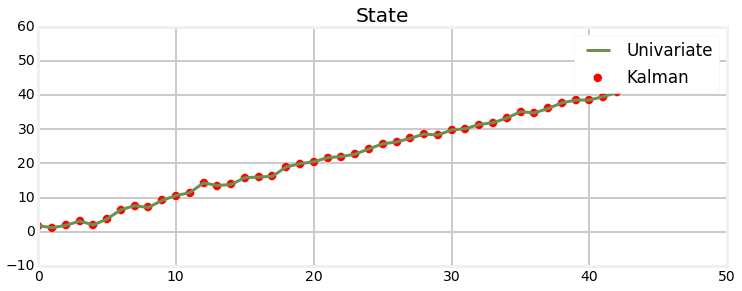

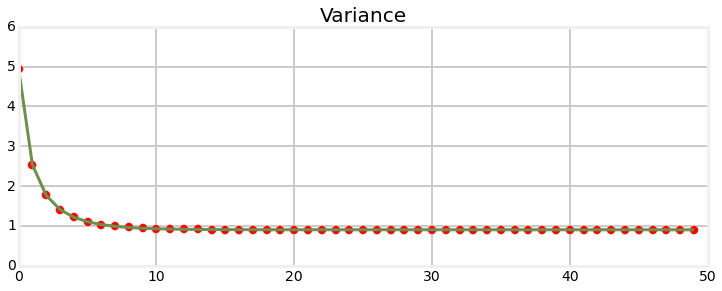

In [20]:
import matplotlib.pyplot as plt

def plot_kf_compare(x0, p0, R, Q, move):
    # storage for filter output
    x_uni, x_kf = [], []
    p1, p2 = [], []

    # initialize the filters
    f = mkf_filter(R, Q)
    f.x[0] = 0.
    f.P[0, 0] = p0
    pos = (x0, p0)
    for i in range(50):
        z = i*move + randn()
        pos = update(pos[0], pos[1], z, R)
        f.update(z)

        x_uni.append(pos[0])
        x_kf.append(f.x[0])

        p1.append(pos[1])
        p2.append(f.P[0, 0])

        u = move + randn()
        pos = predict(pos[0], pos[1], u, Q)
        f.predict(u=u)

    plt.scatter(range(len(x_kf)), x_kf, c='r', s=80, label='Kalman')
    plt.title('State')
    plt.plot(x_uni, label='Univariate')
    plt.xlim([0, 50])
    plt.legend()

    plt.figure()
    plt.plot(p1)
    plt.scatter(range(len(x_kf)), p2, c='r', s=80)
    plt.title('Variance')
    plt.xlim([0, 50])
    plt.show()
    
plot_kf_compare(x0=0., p0=500., R=5., Q=.2, move=1.)

As you can see, both filters produce the same results. Feel free to vary the initial guess, the measurement noise, and the process noise; so long as you make the same changes to both filters the output should be the same. This is a solid demonstration, albeit not a rigorous proof, that both filters in fact implement the same math for the 1-D case. 

## Modeling Dynamic Systems

Modeling dynamic systems is properly the topic of at least one undergraduate course in mathematics. To an extent there is no substitute for a few semesters of ordinary and partial differential equations. If you are a hobbyist, or trying to solve one very specific filtering problem at work you probably do not have the time and/or inclination to devote a year or more to that education.

However, I can present enough of the theory to allow us to create the system equations for many different Kalman filters, and give you enough background to at least follow the mathematics in the literature. My goal is to get you to the stage where you can read a Kalman filtering book or paper and understand it well enough to implement the algorithms. The background math is deep, but we end up using a few simple techniques over and over again in practice.

I struggle a bit with the proper way to present this material. If you have not encountered this math before I fear reading this section will not be very profitable for you. In the **Extended Kalman Filter** chapter I take a more ad-hoc way of presenting this information where I expose a problem that the KF needs to solve, then provide the math without a lot of supporting theory. This gives you the motivation behind the mathematics at the cost of not knowing why the math I give you is correct. On the other hand, the following section gives you the math, but somewhat divorced from the specifics of the problem we are trying to solve. Only you know what kind of learner your are. If you like the presentation of the book so far (practical first, then the math) you may want to wait until you read the **Extended Kalman Filter** before 
In particular, if your intent is to work with Extended Kalman filters (a very prelevant form of nonlinear Kalman filtering) you will need to understand this math at least at the level I present it. If that is not your intent this section may still prove to be beneficial if you need to simulate a nonlinear system in order to test your filter.

Let's lay out the problem and discuss what the solution will be. We  model *dynamic systems* with a set of first order *differential equations*. This should not be a surprise as calculus is the math of things that vary. For example, we say that velocity is the derivative of distance with respect to time

$$\mathbf{v}= \frac{d \mathbf{x}}{d t} = \dot{\mathbf{x}}$$

where $\dot{\mathbf{x}}$ is the notation for the derivative of $\mathbf{x}$ with respect to t.

We need to use these equations for the predict step of the Kalman filter. Given the state of the system at time $t$ we want to predict its state at time $t + \Delta t$. The Kalman filter matrices do not accept differential equations, so we need a mathematical technique that will find the solution to those equations at each time step. In general it is extremely difficult to find analytic solutions to systems of differential equations, so we will normally use *numerical* techniques to find accurate approximations for these equations.

### Why This is Hard

We model dynamic systems with a set of first order differential equations. For example, we already presented the Newtonian equation

$$\mathbf{v}=\dot{\mathbf{x}}$$

where $\dot{\mathbf{x}}$ is the notation for the derivative of $\mathbf{x}$ with respect to t, or $\frac{d \mathbf{x}}{d t}$.

In general terms we can then say that a dynamic system consists of equations of the form

$$ g(t) = \dot{x}$$

if the behavior of the system depends on time. However, if the system is *time invariant* the equations are of the form

$$ f(x) = \dot{x}$$

What does *time invariant* mean? Consider a home stereo. If you input a signal $x$ into it at time $t$, it will output some signal $f(x)$. If you instead make the input at a later time $t + \Delta t$ the output signal will still be exactly the same, just shifted in time. This is different from, say, an aircraft. If you make a control input to the aircraft at a later time it's behavior will be different because it will have burned additional fuel (and thus lost weight), drag may be different due to being at a different altitude, and so on.

We can solve these equations by integrating each side. The time variant equation is very straightforward. We essentially solved this problem with the Newtonian equations above, but let's be explicit and write it out. Starting with  $$\dot{\mathbf{x}}=\mathbf{v}$$ we get the expected

$$ \int \dot{\mathbf{x}}\mathrm{d}t = \int \mathbf{v} \mathrm{d}t\\
x = vt + x_0$$

However, integrating the time invariant equation is not so straightforward. 

$$ \dot{x} = f(x) \\
\frac{dx}{dt} = f(x)
$$ 

Using the *separation of variables* techniques, we divide by $f(x)$ and move the $dx$ term to the right so we can integrate each side:

$$
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt\\
$$

If we let the solution to the left hand side by named $F(x)$, we get

$$F(x) - f(x_0) = t-t_0$$

We then solve for x with

$$F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]$$

In other words, we need to find the inverse of $F$. This is not at all trivial, and a significant amount of course work in a STEM education is devoted to finding tricky, analytic solutions to this problem, backed by several centuries of research. 

In the end, however, they are tricks, and many simple forms of $f(x)$ either have no closed form solution, or pose extreme difficulties. Instead, the practicing engineer turns to numerical methods to find a solution to her problems. I would suggest that students would be better served by learning fewer analytic mathematical tricks and instead focusing on learning numerical methods, but that is the topic for another book.

### Finding the Fundamental Matrix for Time Invariant Systems

 If you already have the mathematical training in solving partial differential equations you may be able to put it to use; I am not assuming that sort of background.  So let me skip over quite a bit of mathematics and present the typical numerical techniques used in Kalman filter design. 

First, we express the system equations in state-space form (i.e. using linear algebra equations) with

$$ \dot{\mathbf{x}} = \mathbf{Fx}$$

Now we can assert that we want to find the fundamental matrix $\Phi$ that propagates the state with the equation

$$x(t) = \Phi(t-t_0)x(t_0)$$

which we can equivalently write as

$$x(t_k) = \Phi(\Delta t)x(t_{k-1})$$

In other words, we just want to compute the value of $x$ at time $t$ by multiplying its previous value by some matrix $\Phi$. This is not trivial to do because the original equations do not include time.

### Taylor Series Expansion

Broadly speaking there are three ways to find $\Phi$ that are used in Kalman filters. The technique most often used with Kalman filters is to use a Taylor-series expansion. The Taylor series represents a function as an infinite sum of terms. The terms are linear, even for a nonlinear function, so we can express any arbitrary nonlinear function using linear algebra. The cost of this choice is that unless we use an infinite number of terms (and who has time for that these days) the value we compute will be approximate rather than exact.

For the Kalman filter we will be using a form of the series that uses a matrix. But before we do that, let's work through a couple of examples with real functions since real functions are easier to plot and reason about. The Taylor series for either are nearly identical, so this is a good first step.
For a real (or complex) function the Taylor series of a function $f(x)$ evaluated at $a$ is defined as 

$$ \Phi(t) = e^{\mathbf{F}t} = \mathbf{I} + \mathbf{F}t  + \frac{(\mathbf{F}t)^2}{2!} + \frac{(\mathbf{F}t)^3}{3!} + ... $$

This is easy to compute, and thus is the typical approach used in Kalman filter design when the filter is reasonably small. If you are wondering where $e$ came from, I point you to the Wikipedia article on the matrix exponential [1]. Here the important point is to recognize the very simple and regular form this equation takes. 

Before applying it to a Kalman filter, lets do the Taylor expansion of a math function since this is much easier to visualize than a matrix. I choose sin(x). The Taylor series for a real or complex function f(x) about x=a is

$$f(x) = \sum_{n=0}^\infty\frac{f^{(n)}(a)}{x!}(x-a)^n$$

where $f^{n}$ is the nth derivative of f. To compute the Taylor series for $f(x)=sin(x)$ at $x=0$ Let's first work out the terms for f.

$$\begin{aligned}
f^{0}(x) &= sin(x) ,\ \  &f^{0}(0) &= 0 \\
f^{1}(x) &= cos(x),\ \  &f^{1}(0) &= 1 \\
f^{2}(x) &= -sin(x),\ \  &f^{2}(0) &= 0 \\
f^{3}(x) &= -cos(x),\ \  &f^{3}(0) &= -1 \\
f^{4}(x) &= sin(x),\ \  &f^{4}(0) &= 0 \\
f^{5}(x) &= cos(x),\ \  &f^{5}(0) &= 1
\end{aligned}
$$

Now we can substitute these values into the equation.

$$f(x) = \frac{0}{0!}(x)^0 + \frac{1}{1!}(x)^1 + \frac{0}{2!}(x)^2 + \frac{-1}{3!}(x)^3 + \frac{0}{4!}(x)^4 + \frac{-1}{5!}(x)^5 + ... $$

And let's test this with some code:

In [21]:
x = .3
estimate = x + x**3/6 + x**5/120
exact = np.sin(.3)

print('estimate of sin(.3) is', estimate)
print('exact value of sin(.3) is', exact)

estimate of sin(.3) is 0.30452025
exact value of sin(.3) is 0.295520206661


This is not bad for only three terms. If you are curious, go ahead and implement this as a Python function to compute the series for an arbitrary number of terms. But I will forge ahead to the matrix form of the equation. 

Let's consider tracking an object moving in a vacuum. In one dimesion the differential equation for motion with zero acceleration is

$$ v = \dot{x}\\a=\ddot{x} =0,$$

which we can put in state space matrix form as

$$\begin{bmatrix}\dot{x} \\ \ddot{x}\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

This is a first order differential equation, so we can set $\mathbf{F}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$ and solve the following equation.

$$\Phi(t) = e^{\mathbf{F}t} = \mathbf{I} + \mathbf{F}t  + \frac{(\mathbf{F}t)^2}{2!} + \frac{(\mathbf{F}t)^3}{3!} + ... $$

If you perform the multiplication you will find that $\mathbf{F}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$, which means that all higher powers of $\mathbf{F}$ are also $\mathbf{0}$. This makes the computation very easy.

$$
\begin{aligned}
\Phi(t) &=\mathbf{I} + \mathbf{F}t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}t\\
&= \begin{bmatrix}1&t\\0&1\end{bmatrix}
\end{aligned}$$

We plug this into $x(t_k) = \Phi(\Delta t)x(t_{k-1})$ to get

$$
\begin{aligned}
x(t_k) &= \Phi(\Delta t)x(t_{k-1}) \\
x^- &= \Phi(\Delta t)x \\
x^- &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x \\
\begin{bmatrix}x \\ \dot{x}\end{bmatrix}^- &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}$$

This should look very familiar to you! This is the equation we used in the **Multivariate Kalman Filter** chapter to track a moving object.

$$
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- =\begin{bmatrix}1&t \\ 0&1\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

We derived this equation in that chapter by using techniques that are much easier to understand. The advantage of the Taylor series expansion is that we can use it for any arbitrary set of differential equations which are time invariant. 

Time invariant? This just means equations that do not depend on time. For example, $f(x) = sin(t)t$ is not time invariant; the value will be different at different times due to the multiplication by t. On the other hand $f(x) = sin(t)*3$ is time invariant. $x(t)$ is dependent on time, but that is allowed. This is because to be time invariant it must be true that if $f(t) = x(t)$ then $f(t+\Delta t) = x(t+\Delta t)$. This will be true for the second equation, but not the first.

However, we often use a Taylor expansion even when the equations are not time invariant. The answer will still be reasonably accurate so long as the time step is short and the system is nearly constant over that time step.

### Linear Time Invariant Theory

*Linear Time Invariant Theory*, also known as LTI System Theory, gives us a way to find $\Phi$ using the inverse Laplace transform. You are either nodding your head now, or completely lost. Don't worry, I will not be using the Laplace transform in this book except in this paragraph, as the computation is quite difficult to perform in practice. LTI system theory tells us that 

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{F})^{-1}]$$

I have no intention of going into this other than to say that the inverse Laplace transform converts a signal into the frequency (time) domain, but finding a solution to the equation above is non-trivial. If you are interested, the Wikipedia article on LTI system theory provides an introduction [2].

### Numerical Solutions
Finally, there are numerical techniques to find $\Phi$. As filters get larger finding analytical solutions becomes very tedious (though packages like SymPy make it easier). C. F. van Loan [3] has developed a technique that finds both $\Phi$ and $Q$ numerically.

I have implemented van Loan's method in `FilterPy`. You may use it as follows:

    from filterpy.common import van_loan_discretization
  
    F = np.array([[0,1],[-1,0]], dtype=float)
    G = np.array([[0.],[2.]]) # white noise scaling
    phi, Q = van_loan_discretization(F, G, dt=0.1)
    
See the docstring documentation for van_loan_discretization for more information, which I have embedded below.

In [22]:
from filterpy.common import van_loan_discretization
help(van_loan_discretization)

Help on function van_loan_discretization in module filterpy.common.discretization:

van_loan_discretization(F, G, dt)
    Discretizes a linear differential equation which includes white noise
    according to the method of C. F. van Loan [1]. Given the continuous
    model
    
        x' =  Fx + Gu
    
    where u is the unity white noise, we compute and return the sigma and Q_k
    that discretizes that equation.
    
    
    **Example**::
    
        Given y'' + y = 2u(t), we create the continuous state model of
    
        x' = | 0 1| * x + |0|*u(t)
             |-1 0|       |2|
    
        and a time step of 0.1:
    
    
        >>> F = np.array([[0,1],[-1,0]], dtype=float)
        >>> G = np.array([[0.],[2.]])
        >>> phi, Q = van_loan_discretization(F, G, 0.1)
    
        >>> phi
        array([[ 0.99500417,  0.09983342],
               [-0.09983342,  0.99500417]])
    
        >>> Q
        array([[ 0.00133067,  0.01993342],
               [ 0.01993342,  0.39866933]

### Forming First Order Equations from Higher Order Equations

In the sections above I spoke of *first order* differential equations; these are equations with only first derivatives. However, physical systems often require second or higher order equations. Any higher order system of equations can be converted to a first order set of equations by defining extra variables for the first order terms and then solving. Let's do an example. 

Given the system $\ddot{x} - 6\dot{x} + 9x = t$ find the first order equations.

The first step is to isolate the highest order term onto one side of the equation .

$$\ddot{x} = 6\dot{x} - 9x + t$$

We define two new variables:

$$ x_1(t) = x \\
x_2(t) = \dot{x}
$$

Now we will substitute these into the original equation and solve, giving us a set of first order equations in terms of these new variables.

First, we know that $\dot{x}_1 = x_2$ and that $\dot{x}_2 = \ddot{x}$. Therefore

$$\begin{aligned}
\dot{x}_2 &= \ddot{x} \\
          &= 6\dot{x} - 9x + t\\
          &= 6x_2-9x_1 + t
\end{aligned}$$

Therefore our first order system of equations is

$$\begin{aligned}\dot{x}_1 &= x_2 \\
\dot{x}_2 &= 6x_2-9x_1 + t\end{aligned}$$

If you practice this a bit you will become adept at it. Just isolate the highest term, define a new variable and its derivatives, and then substitute.

** text ripped from MKF chapter. Needs to be incorporated here somewhere below.**

Recall what happened to our variance when we performed the predict step in the *Discrete Bayes* chapter and the *Kalman Filter* chapter. Because we are predicting forward in time we lose some certainty about the state. In the *Discrete Bayes* chapter we used this code to implement that:

    sigma = sigma + movement_sigma
    
That equation did not take the loss of knowledge due to the process noise into account. We can model the process noise as additional uncertainty, so we could write

In pseudocode we might express this equation as:

    sigma = sigma + movement_sigma + process_noise


In this chapter we do not have multiple state variables, so we have to use linear algebra to perform this computation. 
  
In pseudocode we might express this equation as:
    
    P = project_forward(P) + process_noise

where $P$ is the covariance matrix. The Kalman filter equation corresponding to this pseudocode is

$$\mathbf{P} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$$

In this equation $\mathbf{FP{F}}^\mathsf{T}$ projects $\mathbf{P}$ forward to the next time step according to our motion model $\mathbf{F}$, and $\mathbf{Q}$ is the *process noise matrix*. We are just adding matrices, so hopefully it is clear that each element in $\mathbf{Q}$  specifies how much uncertainty is added to the system due to the process noise. 

Let's take a brief moment to look at the behavior of these equation in more detail. I will project $\mathbf{x}$ forward according to the motion model $\mathbf{F}$ with the equation $\mathbf{x} = \mathbf{Fx}$. Then I will project P to the next timestep with the equation $\mathbf{P} = \mathbf{FP{F}}^\mathsf{T}$. I will draw the original covariance in red and the new covariance in black.

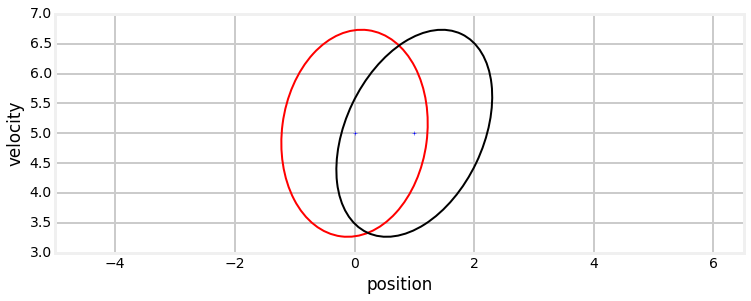

In [23]:
t = 0.2
x = np.array([0., 5.])
F = np.array([[1., t], [0, 1.]])
P = np.array([[1.5, 0.2], [0.2, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

x = np.dot(F, x)
P = np.dot(F, P).dot(F.T)
plt.xlabel('position')
plt.ylabel('velocity')
plot_covariance_ellipse(x, P, edgecolor='k')

Think about what this means. The covariance for $\mathbf{x}$ started at position 0, velocity 5. In 1/5 of a second the position naturally moves to 1, and the velocity is unchanged at 5. The black covariance ellipse is centered at (1, 5), as we would expect. But the ellipse has changed shape. Why? Is it due to the effects of wind, or wheel slippage that I mentioned earlier? No. Think hard about this before you read the answer - this is important, and it will be rewarding to figure it out yourself.

The covariance matrix is ($\begin{smallmatrix}1.5& 0.2\\ 0.2& 3\end{smallmatrix}$). This means that the variance for the velocity if $\sigma^2_{vel}=3.0$. In other words, we think the velocity is 5, but we have some uncertainty about it. We compute the next position as $position_t = position_{t-1} + .2_{sec} * 5$. But we are uncertain about the velocity 5, so we must also be uncertain about the results of this computation! After all, the velocity might actually be 6, or 4.7, or some other value. Our uncertainty about the position must grow from the initial value of $\sigma^2_{pos}=1.5$. We can see from the graph that it has - the ellipse is longer in the position axis.

Let's see this over a longer time period. I will run it for 10 iterations.b

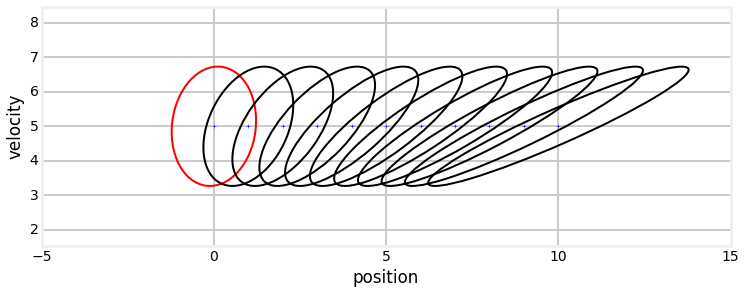

In [24]:
t = 0.2
x = np.array([0., 5.])
F = np.array([[1., t], [0, 1.]])
P = np.array([[1.5, 0.2], [0.2, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(10):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plot_covariance_ellipse(x, P, edgecolor='k')

You can see that over time our uncertainty in the position grows. However, our uncertainty in the velocity does not. Why is that? Well, our process model states that the velocity is constant, and we do not model the possibility that there is error in the model (so far!). We assume the model is perfect, so the variance of the velocity does not change.

So I have demonstrated the reason for the $\mathbf{FP{F}}^\mathsf{T}$ part of the equation, which assumes a perfect model. But of course no model is perfect. Except perhaps in a perfect vacuum velocity will never remain constant. If we are tracking a car, for example, even if we set the cruise control the car will slightly change velocity due to the wind, hills, bumps in the road, imperfections in the cruise control, and so on. If the Kalman filter used the equation above it would quickly become over-certain in its computations. Recall that in the unidimensional Kalman filter chapter every predict cycle increased our uncertainty, and every update decreased it. The same needs to happen here.

This is where $\mathbf{Q}$ comes in. It is a covariance matrix that describes how much *process noise* is in the system. That is just a fancy way of saying how much uncertainty gets added to the system by things we haven't modeled.

Let's rerun this simulation, but this time by using the full equation $\mathbf{P} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$.

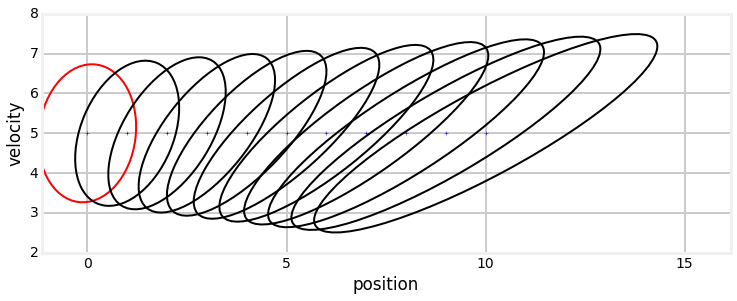

In [25]:
t = 0.2
x = np.array([0., 5.])
F = np.array([[1., t], [0, 1.]])
P = np.array([[1.5, 0.2], [0.2, 3.]])
Q = np.array([[.0004, .004], [.004, .04]]) * 8.
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(10):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T) + Q
    plt.xlabel('position')
    plt.ylabel('velocity')
    plot_covariance_ellipse(x, P, edgecolor='k')



**author's note: I think I go WAY TO MUCH into Q here -- get the poor reader to the implementation!**

I'll address the computation of $\mathbf{Q}$ in the next paragraph. For now you can see that as time passes our uncertainty in velocity is growing slowly. It is a bit harder to see, but if you compare this graph to the previous one the uncertainty in position also increased.

We have not given the math for computing the elements of $\mathbf{Q}$ yet, but if you suspect the math is sometimes difficult you would be correct. One of the problems is that we are usually modeling a *continuous* system - the behavior of the system is changing at every instant, but the Kalman filter is *discrete*. That means that we have to somehow convert the continuous noise of the system into a discrete value, which usually involves calculus. There are other difficulties I will not mention now.

However, for the class of problems we are solving in this chapter (*discretized continuous-time kinematic filters*) we can directly compute the state equations for moving objects by using Newton's equations.

For these kinds of problems we can rely on precomputed forms for $\mathbf{Q}$. We will learn how to derive these matrices in the next chapter. For now I present them without proof. If we assume that for each time period the acceleration due to process noise is constant and uncorrelated, we get the following.

For constant velocity the form is

$$\begin{bmatrix}
\frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 \\
\frac{1}{2}{\Delta t}^3 & \Delta t^2
\end{bmatrix}\sigma^2
$$

and for constant acceleration we have

$$\begin{bmatrix}
\frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 & \frac{1}{2}{\Delta t}^2 \\
\frac{1}{2}{\Delta t}^3 & {\Delta t}^2 & \Delta t \\
\frac{1}{2}{\Delta t}^2 & \Delta t & 1
\end{bmatrix} \sigma^2
$$

It general it is not true that acceleration will be constant and uncorrelated, but this is still a useful approximation for moderate time period, and will suffice for this chapter. Fortunately you can get a long way with approximations and simulation. Let's think about what these matrices are implying. We are trying to model the effects of *process noise*, such as the wind buffeting the flight of a thrown ball. Variations in wind will cause changes in acceleration, and so the effect on the acceleration is large. However, the effects on velocity and position are proportionally smaller. In the matrices, the acceleration term is in the lower right, and this is the largest value. **A good rule of thumb is to set $\sigma$ somewhere from $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample periods**. In practice we pick a number, run simulations on data, and choose a value that works well. 

The filtered result will not be optimal, but in my opinion the promise of optimal results from Kalman filters is mostly wishful thinking. Consider, for example, tracking a car. In that problem the process noise would include things like potholes, wind gusts, changing drag due to turning, rolling down windows, and many more factors. We cannot realistically model that analytically, and so in practice we work out a simplified model, compute $\mathbf{Q}$ based on that simplified model, and then add *a bit more* to  $\small\mathbf{Q}$ in hopes of taking the incalculable factors into account. Then we use a lot of simulations and trial runs to see if the filter behaves well; if it doesn't we adjust $\small\mathbf{Q}$ until the filter performs well. In this chapter we will focus on forming an intuitive understanding on how adjusting $\small\mathbf{Q}$ affects the output of the filter. In the Kalman Filter Math chapter we will discuss the analytic computation of $\small\mathbf{Q}$, and also provide code that will compute it for you.

For now we will just import the code from the `FilterPy` module, where it is already implemented. I will import it and call help on it so you can see the documentation for it.

## Design of the Process Noise Matrix

**Author's note: this section contains some of the more challenging math in this book. Please bear with it, as few books cover this well, and an accurate design is imperative for good filter performance. At the end I present Python functions from FilterPy which will compute the math for you for common scenarios.**

In general the design of the $\mathbf{Q}$ matrix is among the most difficult aspects of Kalman filter design. This is due to several factors. First, the math itself is somewhat difficult and requires a good foundation in signal theory. Second, we are trying to model the noise in something for which we have little information. For example, consider trying to model the process noise for a baseball. We can model it as a sphere moving through the air, but that leave many unknown factors - the wind, ball rotation and spin decay, the coefficient of friction of a scuffed ball with stitches, the effects of wind and air density, and so on. I will develop the equations for an exact mathematical solution for a given process model, but since the process model is incomplete the result for $\mathbf{Q}$ will also be incomplete. This has a lot of ramifications for the behavior of the Kalman filter. If $\mathbf{Q}$ is too small than the filter will be overconfident in it's prediction model and will diverge from the actual solution. If $\mathbf{Q}$ is too large than the filter will be unduly influenced by the noise in the measurements and perform sub-optimally. In practice we spend a lot of time running simulations and evaluating collected data to try to select an appropriate value for $\mathbf{Q}$. But let's start by looking at the math.


Let's assume a kinematic system - some system that can be modeled using Newton's equations of motion. We can make a few different assumptions about this process. 

We have been using a process model of

$$ f(\mathbf{x}) = \mathbf{Fx} + \mathbf{w}$$

where $\mathbf{w}$ is the process noise. Kinematic systems are *continuous* - their inputs and outputs can vary at any arbitrary point in time. However, our Kalman filters are *discrete*. We sample the system at regular intervals. Therefore we must find the discrete representation for the noise term in the equation above. However, this depends on what assumptions we make about the behavior of the noise. We will consider two different models for the noise.

### Continuous White Noise Model

We model kinematic systems using Newton's equations. So far in this book we have either used position and velocity, or position,velocity, and acceleration as the models for our systems. There is nothing stopping us from going further - we can model jerk, jounce, snap, and so on. We don't do that normally because adding terms beyond the dynamics of the real system actually degrades the solution. 

Let's say that we need to model the position, velocity, and acceleration. We can then assume that acceleration is constant. Of course, there is process noise in the system and so the acceleration is not actually constant. In this section we will assume that the acceleration changes by a continuous time zero-mean white noise $w(t)$. In other words, we are assuming that velocity is acceleration changing by small amounts that over time average to 0 (zero-mean). 

Since the noise is changing continuously we will need to integrate to get the discrete noise for the discretization interval that we have chosen. We will not prove it here, but the equation for the discretization of the noise is

$$\mathbf{Q} = \int_0^{\Delta t} \Phi(t)\mathbf{Q_c}\Phi^\mathsf{T}(t) dt$$

where $\mathbf{Q_c}$ is the continuous noise. This gives us

$$\Phi = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

for the fundamental matrix, and

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

for the continuous process noise matrix, where $\Phi_s$ is the spectral density of the white noise.

We could carry out these computations ourselves, but I prefer using SymPy to solve the equation.

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$



In [26]:
import sympy
from sympy import init_printing, Matrix,MatMul, integrate, symbols

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q=sympy.integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
sympy.MatMul(Q, phi)

ImportError: No module named sympy

For completeness, let us compute the equations for the 0th order and 1st order equations.

In [ ]:
F_k = sympy.Matrix([[1]])
Q_c = sympy.Matrix([[phi]])

print('0th order discrete process noise')
sympy.integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

In [ ]:
F_k = sympy.Matrix([[1, dt],
                    [0, 1]])
Q_c = sympy.Matrix([[0, 0],
                    [0, 1]])*phi

Q = sympy.integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
sympy.MatMul(Q, phi)

### Piecewise White Noise Model

Another model for the noise assumes that the that highest order term (say, acceleration) is constant for each time period, but differs for each time period, and each of these is uncorrelated between time periods. This is subtly different than the model above, where we assumed that the last term had a continuously varying noisy signal applied to it.  

We will model this as

$$f(x)=Fx+\Gamma w$$

where $\Gamma$ is the *noise gain* of the system, and $w$ is the constant piecewise acceleration (or velocity, or jerk, etc). 

Lets start with by looking a first order system. In this case we have the state transition function

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

In one time period, the change in velocity will be $w(t)\Delta t$, and the change in position will be $w(t)\Delta t^2/2$, giving us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

The covariance of the process noise is then

$$Q = E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

We can compute that with SymPy as follows

In [ ]:
var=symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
sympy.MatMul(Q, var)

The second order system proceeds with the same math.


$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

Here we will assume that the white noise is a discrete time Wiener process. This gives us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

There is no 'truth' to this model, it is just convenient and provides good results. For example, we could assume that the noise is applied to the jerk at the cost of a more complicated equation. 

The covariance of the process noise is then

$$Q = E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

We can compute that with SymPy as follows

In [ ]:
var=symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
sympy.MatMul(Q, var)

We cannot say that this model is more or less correct than the continuous model - both are approximations to what is happening to the actual object. Only experience and experiments can guide you to the appropriate model. In practice you will usually find that either model provides reasonable results, but typically one will perform better than the other.

The advantage of the second model is that we can model the noise in terms of $\sigma^2$ which we can describe in terms of the motion and the amount of error we expect. The first model requires us to specify the spectral density, which is not very intuitive, but it handles varying time samples much more easily since the noise is integrated across the time period. However, these are not fixed rules - use whichever model (or a model of your own devising) based on testing how the filter performs and/or your knowledge of the behavior of the physical model.

### Using FilterPy to Compute Q

FilterPy offers several routines to compute the $\mathbf{Q}$ matrix. The function `Q_continuous_white_noise()` computes $\mathbf{Q}$ for a given value for $\Delta t$ and the spectral density.

In [ ]:
import filterpy.common as common

common.Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)

In [ ]:
common.Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)

The function `Q_discrete_white_noise()` computes $\mathbf{Q}$ assuming a piecewise model for the noise.

In [ ]:
common.Q_discrete_white_noise(2, var=1.)

In [ ]:
common.Q_discrete_white_noise(3, var=1.)

### Simplification of Q

Through the early parts of this book I used a much simpler form for $\mathbf{Q}$, often only putting a noise term in the lower rightmost element. Is this justified? Well, consider the value of $\mathbf{Q}$ for a small $\Delta t$

In [ ]:
common.Q_continuous_white_noise(dim=3, dt=0.05, spectral_density=1)

We can see that most of the terms are very small. Recall that the only Kalman filter using this matrix is

$$ \mathbf{P}=\mathbf{FPF}^\mathsf{T} + \mathbf{Q}$$

If the values for $\mathbf{Q}$ are small relative to $\mathbf{P}$
than it will be contributing almost nothing to the computation of $\mathbf{P}$. Setting $\mathbf{Q}$ to 

$$\mathbf{Q}=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

while not correct, is often a useful approximation. If you do this you will have to perform quite a few studies to guarantee that your filter works in a variety of situations. Given the availability of functions to compute the correct values of $\mathbf{Q}$ for you I would strongly recommend not using approximations. Perhaps it is justified for quick-and-dirty filters, or on embedded devices where you need to wring out every last bit of performance, and seek to minimize the number of matrix operations required. 


** author's note: the following aside probably belongs elsewhere in the book**

> As an aside, most textbooks are more exact with the notation, in Gelb[1] for example, *Pk(+)* is used to denote the uncertainty covariance for the prediction step, and *Pk(-)* for the uncertainty covariance for the update step. Other texts use subscripts with 'k|k-1', superscript $^-$, and many other variations. As a programmer I find all of that fairly unreadable; I am used to thinking about variables changing state as a program runs, and do not use a different variable name for each new computation. There is no agreed upon format, so each author makes different choices. I find it challenging to switch quickly between books an papers, and so have adopted this admittedly less precise notation. Mathematicians will write scathing emails to me, but I hope the programmers and students will rejoice.

> If you are a programmer trying to understand a paper's math equations, I strongly recommend just removing all of the superscripts, subscripts, and diacriticals, replacing them with a single letter. If you work with equations like this every day this is superfluous advice, but when I read I am usually trying to understand the flow of computation. To me it is far more understandable to remember that $P$ in this step represents the updated value of $P$ computed in the last step, as opposed to trying to remember what $P_{k-1}(+)$ denotes, and what its relation to $P_k(-)$ is, if any.

> For example, for the equation of $\mathbf{S}$ above, Wikipedia uses

> $$\textbf{S}_k = \textbf{H}_k \textbf{P}_{k\mid k-1} \textbf{H}_k^\mathsf{T} + \textbf{R}_k
$$

> Is that more exact? Absolutely. Is it easier or harder to read? You'll need to answer that for yourself.

> For reference, the Appendix **Symbols and Notations** lists the symbology used by the major authors in the field.

## Numeric Integration of Differential Equations

** author's note: this is just notes to a section. If you need to know this in depth, 
*Computational Physics in Python * by Dr. Eric Ayars is excellent, and available here.
http://phys.csuchico.edu/ayars/312/Handouts/comp-phys-python.pdf **

So far in this book we have been working with systems that can be expressed with simple linear differential equations such as

$$v = \dot{x} = \frac{dx}{dt}$$

which we can integrate into a closed form solution, in this case $x(t) =vt + x_0$. This equation is then put into the system matrix $\mathbf{F}$, which allows the Kalman filter equations to predict the system state in the future. For example, our constant velocity filters use

$$\mathbf{F} = \begin{bmatrix}
1 & \Delta t \\ 0 & 1\end{bmatrix}$$.


The Kalman filter predict equation is $\mathbf{x}^- = \mathbf{Fx} + \mathbf{Bu}$. Hence the prediction is

$$\mathbf{x}^- = \begin{bmatrix}
1 & \Delta t \\ 0 & 1\end{bmatrix}\begin{bmatrix}
x\\ \dot{x}\end{bmatrix}
$$

which multiplies out to 

$$\begin{aligned}x^- &= x + v\Delta t \\
\dot{x}^- &= \dot{x}\end{aligned}$$.

This works for linear ordinary differential equations (ODEs), but does not work (well) for nonlinear equations. For example, consider trying to predict the position of a rapidly turning car. Cars turn by pivoting the front wheels, which cause the car to pivot around the rear axle. Therefore the path will be continuously varying and a linear prediction will necessarily produce an incorrect value. If the change in the system is small enough relative to $\Delta t$ this can often produce adequate results, but that will rarely be the case with the nonlinear Kalman filters we will be studying in subsequent chapters. Another problem is that even trivial systems produce differential equations for which finding closed form solutions is difficult or impossible. 

For these reasons we need to know how to numerically integrate differential equations. This can be a vast topic, and SciPy provides integration routines such as `scipy.integrate.ode`. These routines are robust, but 

## Euler's Method

Let's say we have the initial condition problem of 

$$ y' = y, \\ y(0) = 1$$

I happen to know the exact answer is $y=e^t$, but of course in general we will not know the exact solution. In general all we know is the derivative of the equation, which is equal to the slope. We also know the initial value: at $t=0$, $y=1$. If we know these two pieces of information we can predict that value for y(1): it is the slope of the function at $t=0$. I've plotted this below

In [ ]:
import numpy as np
t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot(t,t+1)
plt.show()

If the curve is relatively straight than the line formed by the slope will not be very far from the curve. Here the step size of 1 is rather large; you can see that the slope is very close to the line at, say, 0.1. But let's continue with a step size of 1 for a moment. We can see that at $t=1$ the estimated value of $y$ is 2. Now we can compute the value at $t=2$ by taking the slope of the curve at $t=1$ and adding it to our initial estimate. The slope is computed with $y'=y$, so the slope is 2.

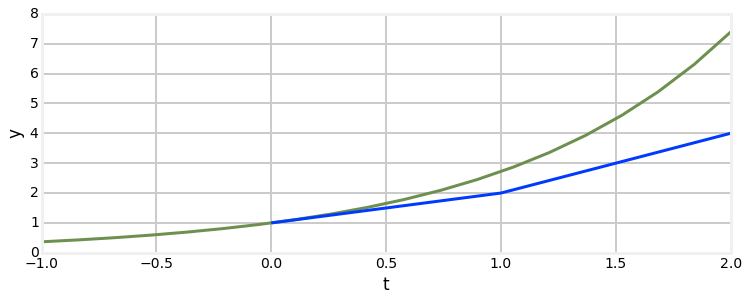

In [27]:
t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1,2, 4])
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Here we see the next estimate for y is 4. The errors are quickly getting large, and you might be unimpressed. But 1 is a very large step size. Let's put this algorithm in code, and verify that it works by trying to generate the result above.

In [28]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [29]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


This looks correct. So now lets plot the result of a much smaller step size.

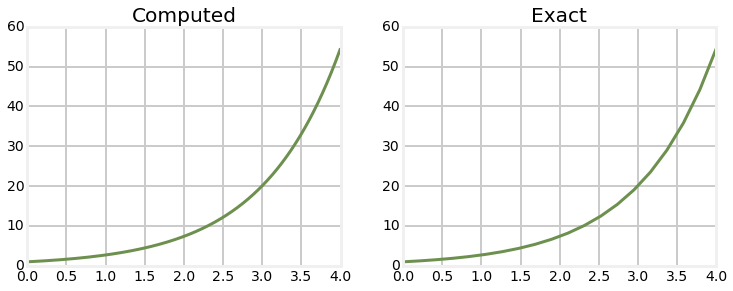

In [30]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t))
plt.show()

In [31]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.5981500331
euler answer= 54.5970580883
difference = 0.00109194480299
iterations = 400000


Here we see that the error is reasonably small, but it took a very large number of iterations to get three digits of precision. In practice Euler's method is too slow for most problems, and we use higher level methods.

Before we go on, let's formally derive Euler's method, as it is the basis for the more advanced Runge Kutta methods used in the next section. In fact, Euler's method is the simplest form of Runge Kutta.


Here are the first 3 terms of the Euler expansion of $y$. An infinite expansion would give an exact answer, so $O(h^4)$ denotes the error due to the finite expansion.

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) +  O(h^4).$$

Here we can see that Euler's method is just using the first two terms of the Taylor expansion. Each subsequent term is smaller than the previous terms, so we are assured that the estimate will not be too far off from the correct value. 

### Runge Kutta Methods


Runge Kutta integration is the workhorse of numerical integration. As mentioned earlier there are a vast number of methods in the literature. In practice, using the Runge Kutta algorithm that I present here will solve most any problem you will face. It offers a very good balance of speed, precision, and stability, and it is the 'go to' numerical integration method unless you have a very good reason to choose something different. If you have the knowledge to make that decision you have no need to be reading this section!

Let's just dive in. We start with some differential equation

$$\ddot{y} = \frac{d}{dt}\dot{y}$$.

We can substitute the derivative of y with a function f, like so

$$\ddot{y} = \frac{d}{dt}f(y,t)$$.

Deriving these equations is outside the scope of this book, but the Runge Kutta RK4 method is defined with these equations.

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$


In [32]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to compute dy/dx for
      the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

Let's use this for a simple example. Let

$$\dot{y} = t\sqrt{y(t)}$$

with the initial values

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

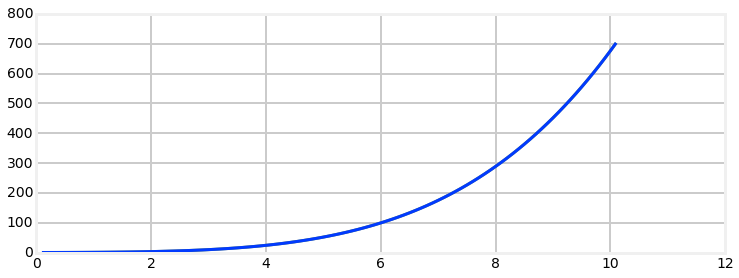

max error 5.20697003594e-05


In [33]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt

    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)
plt.show()

error = np.array(exact) - np.array(ys)
print("max error {}".format(max(error)))

## Iterative Least Squares for Sensor Fusion

A broad category of use for the Kalman filter is *sensor fusion*. For example, we might have a position sensor and a velocity sensor, and we want to combine the data from both to find an optimal estimate of state. In this section we will discuss a different case, where we have multiple sensors providing the same type of measurement. 

 The Global Positioning System (GPS) is designed so that at least 6 satellites are in view at any time at any point on the globe. The GPS receiver knows the location of the satellites in the sky relative to the Earth. At each epoch (instant in time) the receiver gets a signal from each satellite from which it can derive the *pseudorange* to the satellite. In more detail, the GPS receiver gets a signal identifying the satellite along with the time stamp of when the signal was transmitted. The GPS satellite has an atomic clock on board so this time stamp is extremely accurate. The signal travels at the speed of light, which is constant in a vacuum, so in theory the GPS should be able to produce an extremely accurate distance measurement to the measurement by measuring how long the signal took to reach the receiver. There are several problems with that. First, the signal is not traveling through a vacuum, but through the atmosphere. The atmosphere causes the signal to bend, so it is not traveling in a straight line. This causes the signal to take longer to reach the receiver than theory suggests. Second, the on board clock on the GPS *receiver* is not very accurate, so deriving an exact time duration is nontrivial. Third, in many environments the signal can bounce off of buildings, trees, and other objects, causing either a longer path or *multipaths*, in which case the receive receives both the original signal from space and the reflected signals. 

Let's look at this graphically. I will due this in 2D just to make it easier to graph and see, but of course this will generalize to three dimensions. We know the position of each satellite and the range to each (the range is called the *pseudorange*; we will discuss why later). We cannot measure the range exactly, so there is noise associated with the measurement, which I have depicted with the thickness of the lines. Here is an example of four pseudorange readings from four satellites. I positioned them in a configuration which is unlikely for the actual GPS constellation merely to make the intersections easy to visualize. Also, the amount of error shown is not to scale with the distances, again to make it easier to see.

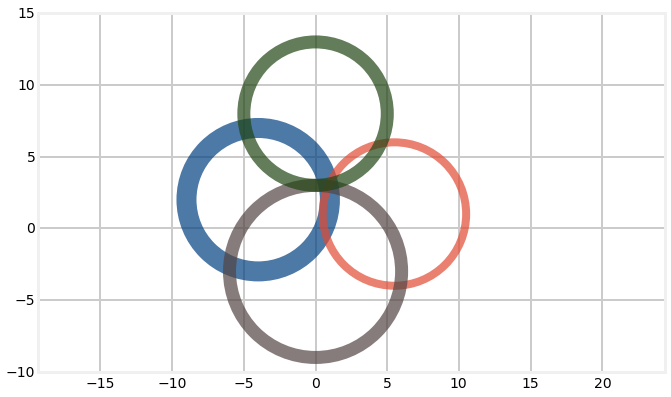

In [34]:
import ukf_internal
with book_format.figsize(10, 6):
    ukf_internal.show_four_gps()

In 2D two measurements are typically enough to determine a unique solution. There are two intersections of the range circles, but usually the second intersection is not physically realizable (it is in space, or under ground). However, with GPS we also need to solve for time, so we would need a third measurement to get a 2D position.

However, since GPS is a 3D system we need to solve for the 3 dimensions of space, and 1 dimension of time. That is 4 unknowns, so in theory with 4 satellites we have all the information we need. However, we normally have at least 6 satellites in view, and often more than 6. This means the system is *overdetermined*. Finally, because of the noise in the measurements none of pseudoranges intersect exactly.

If you are well versed in linear algebra you know that this an extremely common problem in scientific computing, and that there are various techniques for solving overdetermined systems. Probably the most common approach used by GPS receivers to find the position is the *iterative least squares* algorithm, commonly abbreviated ILS. As you know, if the errors are Gaussian then the least squares algorithm finds the optimal solution. In other words, we want to minimize the square of the residuals for an overdetermined system.

Let's start with some definitions which should be familiar to you. First, we define the innovation as 

$$\delta \mathbf{z}^-= \mathbf{z} - h(\mathbf{x}^-)$$

where $\mathbf{z}$ is the measurement, $h(\bullet)$ is the measurement function, and $\delta \mathbf{z}^-$ is the innovation, which we abbreviate as $y$ in FilterPy. I don't use the $\mathbf{x}^-$ symbology often, but it is the prediction for the state variable. In other words, this is just the equation $\mathbf{y} = \mathbf{z} - \mathbf{Hx}$ in the linear Kalman filter's update step.

Next, the *measurement residual* is

$$\delta \mathbf{z}^+ = \mathbf{z} - h(\mathbf{x}^+)$$

I don't use the plus superscript much because I find it quickly makes the equations unreadable, but $\mathbf{x}^+$ it is just the *a posteriori* state estimate, which is just the predicted or unknown future state. In other words, the predict step of the linear Kalman filter computes this value. Here it is stands for the value of x which the ILS algorithm will compute on each iteration.

These equations give us the following linear algebra equation:

$$\delta \mathbf{z}^- = \mathbf{H}\delta \mathbf{x} + \delta \mathbf{z}^+$$

$\mathbf{H}$ is our measurement function, defined as

$$\mathbf{H} = \frac{d\mathbf{h}}{d\mathbf{x}} = \frac{d\mathbf{z}}{d\mathbf{x}}$$

We find the minimum of an equation by taking the derivative and setting it to zero. In this case we want to minimize the square of the residuals, so our equation is

$$ \frac{\partial}{\partial \mathbf{x}}({\delta \mathbf{z}^+}^\mathsf{T}\delta \mathbf{z}^+) = 0,$$

where

$$\delta \mathbf{z}^+=\delta \mathbf{z}^- - \mathbf{H}\delta \mathbf{x}.$$

Here I have switched to using the matrix $\mathbf{H}$ as the measurement function. We want to use linear algebra to peform the ILS, so for each step we will have to compute the matrix $\mathbf{H}$ which corresponds to $h(\mathbf{x^-})$ during each iteration.  $h(\bullet)$ is usually nonlinear for these types of problems so you will have to linearize it at each step (more about this soon).

For various reasons you may want to weigh some measurement more than others. For example, the geometry of the problem might favor orthogonal measurements, or some measurements may be more noisy than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf{x}}({\delta \mathbf{z}^+}^\mathsf{T}\mathbf{W}\delta \mathbf{z}^+) = 0$$

If we solve the first equation for ${\delta \mathbf{x}}$ (the derivation is shown in the next section) we get

$${\delta \mathbf{x}} = {{(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}}\mathbf{H}^\mathsf{T} \delta \mathbf{z}^-}
$$

And the second equation yields

$${\delta \mathbf{x}} = {{(\mathbf{H}^\mathsf{T}\mathbf{WH})^{-1}}\mathbf{H}^\mathsf{T}\mathbf{W} \delta \mathbf{z}^-}
$$

Since the equations are overdetermined we cannot solve these equations exactly so we use an iterative approach. An initial guess for the position is made, and this guess is used to compute  for $\delta \mathbf{x}$ via the equation above. $\delta \mathbf{x}$ is added to the intial guess, and this new state is fed back into the equation to produce another $\delta \mathbf{x}$. We iterate in this manner until the difference in the measurement residuals is suitably small.

### Derivation of ILS Equations (Optional)

I will implement the ILS in code, but first let's derive the equation for $\delta \mathbf{x}$. You can skip the derivation if you want, but it is somewhat instructive and not too hard if you know basic linear algebra and partial differential equations.

Substituting $\delta \mathbf{z}^+=\delta \mathbf{z}^- - \mathbf{H}\delta \mathbf{x}$ into the partial differential equation we get

$$ \frac{\partial}{\partial \mathbf{x}}(\delta \mathbf{z}^- -\mathbf{H} \delta \mathbf{x})^\mathsf{T}(\delta \mathbf{z}^- - \mathbf{H} \delta \mathbf{x})=0$$

which expands to

$$ \frac{\partial}{\partial \mathbf{x}}({\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H}\delta \mathbf{x} - 
{\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\delta \mathbf{z}^- - 
{\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}\delta \mathbf{x} +
{\delta \mathbf{z}^-}^\mathsf{T}\delta \mathbf{z}^-)=0$$

We know that 

$$\frac{\partial \mathbf{A}^\mathsf{T}\mathbf{B}}{\partial \mathbf{B}} = \frac{\partial \mathbf{B}^\mathsf{T}\mathbf{A}}{\partial \mathbf{B}} = \mathbf{A}^\mathsf{T}$$

Therefore the third term can be computed as

$$\frac{\partial}{\partial \mathbf{x}}{\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}\delta \mathbf{x} = {\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}$$

and the second term as

$$\frac{\partial}{\partial \mathbf{x}}{\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\delta \mathbf{z}^-={\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}$$

We also know that
$$\frac{\partial \mathbf{B}^\mathsf{T}\mathbf{AB}}{\partial \mathbf{B}} = \mathbf{B}^\mathsf{T}(\mathbf{A} + \mathbf{A}^\mathsf{T})$$

Therefore the first term becomes

$$
\begin{aligned}
\frac{\partial}{\partial \mathbf{x}}{\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H}\delta \mathbf{x} &= {\delta \mathbf{x}}^\mathsf{T}(\mathbf{H}^\mathsf{T}\mathbf{H} + {\mathbf{H}^\mathsf{T}\mathbf{H}}^\mathsf{T})\\
&= {\delta \mathbf{x}}^\mathsf{T}(\mathbf{H}^\mathsf{T}\mathbf{H} + \mathbf{H}^\mathsf{T}\mathbf{H}) \\
&= 2{\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H}
\end{aligned}$$

Finally, the fourth term is

$$ \frac{\partial}{\partial \mathbf{x}}
{\delta \mathbf{z}^-}^\mathsf{T}\delta \mathbf{z}^-=0$$

Replacing the terms in the expanded partial differential equation gives us

$$
 2{\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H} -
 {\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H} - {\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}
 =0
$$

$${\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H} -
 {\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H} = 0$$
 
$${\delta \mathbf{x}}^\mathsf{T}\mathbf{H}^\mathsf{T}\mathbf{H} =
 {\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}$$

Multiplying each side by $(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}$ yields

$${\delta \mathbf{x}}^\mathsf{T} =
{\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}$$

Taking the transpose of each side gives

$${\delta \mathbf{x}} = ({{\delta \mathbf{z}^-}^\mathsf{T}\mathbf{H}(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}})^\mathsf{T} \\
={{(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}}^T\mathbf{H}^\mathsf{T} \delta \mathbf{z}^-} \\
={{(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}}\mathbf{H}^\mathsf{T} \delta \mathbf{z}^-}
$$

For various reasons you may want to weigh some measurement more than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf{x}}({\delta \mathbf{z}}^\mathsf{T}\mathbf{W}\delta \mathbf{z}) = 0$$

Replicating the math above with the added $\mathbf{W}$ term results in

$${\delta \mathbf{x}} = {{(\mathbf{H}^\mathsf{T}\mathbf{WH})^{-1}}\mathbf{H}^\mathsf{T}\mathbf{W} \delta \mathbf{z}^-}
$$

### Implementing Iterative Least Squares

Our goal is to implement an iterative solution to 
$${\delta \mathbf{x}} = {{(\mathbf{H}^\mathsf{T}\mathbf{H})^{-1}}\mathbf{H}^\mathsf{T} \delta \mathbf{z}^-}
$$

First, we have to compute $\mathbf{H}$, where $\mathbf{H} =  d\mathbf{z}/d\mathbf{x}$. Just to keep the example small so the results are easier to interpret we will do this in 2D. Therefore for $n$ satellites $\mathbf{H}$ expands to

$$\mathbf{H} = \begin{bmatrix}
\frac{\partial p_1}{\partial x_1} & \frac{\partial p_1}{\partial y_1} \\
\frac{\partial p_2}{\partial x_2} & \frac{\partial p_2}{\partial y_2} \\
\vdots & \vdots \\
\frac{\partial p_n}{\partial x_n} & \frac{\partial p_n}{\partial y_n}
\end{bmatrix}$$

We will linearize $\mathbf{H}$ by computing the partial for $x$ as

$$ \frac{estimated\_x\_position - satellite\_x\_position}{estimated\_range\_to\_satellite}$$

The equation for $y$ just substitutes $y$ for $x$.

Then the algorithm is as follows.

    def ILS:
        guess position
        while not converged:
            compute range to satellites for current estimated position
            compute H linearized at estimated position
            compute new estimate delta from (H^T H)'H^T dz
            new estimate = current estimate + estimate delta
            check for convergence
            

In [34]:
import numpy as np
from numpy.linalg import norm, inv
from numpy.random import randn
from numpy import dot


np.random.seed(1234)
user_pos = np.array([800, 200])


sat_pos = np.asarray(
    [[0, 1000],
     [0, -1000],
     [500, 500]], dtype=float)

def satellite_range(pos, sat_pos):
    """ Compute distance between position 'pos' and the list of positions
    in sat_pos"""

    N = len(sat_pos)
    rng = np.zeros(N)

    diff = np.asarray(pos) - sat_pos

    for i in range(N):
        rng[i] = norm(diff[i])

    return norm(diff, axis=1)


def hx_ils(pos, sat_pos, range_est):
    """ compute measurement function where
    pos : array_like 
        2D current estimated position. e.g. (23, 45)
        
    sat_pos : array_like of 2D positions
        position of each satellite e.g. [(0,100), (100,0)]
        
    range_est : array_like of floats
        range to each satellite
    """
    
    N = len(sat_pos)
    H = np.zeros((N, 2))
    for j in range(N):
        H[j, 0] = (pos[0] - sat_pos[j, 0]) / range_est[j]
        H[j, 1] = (pos[1] - sat_pos[j, 1]) / range_est[j]
    return H


def lop_ils(zs, sat_pos, pos_est, hx, eps=1.e-6):
    """ iteratively estimates the solution to a set of measurement, given
    known transmitter locations"""
    pos = np.array(pos_est)

    with book_format.numpy_precision(precision=4):
        converged = False
        for i in range(20):
            r_est = satellite_range(pos, sat_pos)
            print('iteration:', i)

            H = hx(pos, sat_pos, r_est)        
            Hinv = inv(dot(H.T, H)).dot(H.T)

            # update position estimate
            y = zs - r_est
            print('innovation', y)

            Hy = np.dot(Hinv, y)
            pos = pos + Hy
            print('pos       {}\n\n'.format(pos))

            if max(abs(Hy)) < eps:
                converged = True
                break

    return pos, converged

# compute measurement of where you are with respect to each sensor
rz = satellite_range(user_pos, sat_pos)

pos, converted = lop_ils(rz, sat_pos, (900, 90), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 0
innovation [-148.512    28.6789 -148.5361]
pos       [ 805.4175  205.2868]


iteration: 1
innovation [-0.1177 -7.4049 -0.1599]
pos       [ 800.04    199.9746]


iteration: 2
innovation [-0.0463 -0.001  -0.0463]
pos       [ 800.  200.]


iteration: 3
innovation [-0. -0. -0.]
pos       [ 800.  200.]


Iterated solution:  [ 800.  200.]


So let's think about this. The first iteration is essentially performing the computation that the linear Kalman filter computes during the update step:

$$\mathbf{y} = \mathbf{z} - \mathbf{Hx}\\
\mathbf{x} = \mathbf{x} + \mathbf{Ky}$$

where the Kalman gain equals one. You can see that despite the very inaccurate initial guess (900, 90) the computed value for $\mathbf{x}$, (805.4, 205.3), was very close to the actual value of (800, 200). However, it was not perfect. But after three iterations the ILS algorithm was able to find the exact answer. So hopefully it is clear why we use ILS instead of doing the sensor fusion with the Kalman filter - it gives a better result. Of course, we started with a very inaccurate guess; what if the guess was better?

In [35]:
pos, converted = lop_ils(rz, sat_pos, (801, 201), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 0
innovation [-0.0009 -1.3868 -0.0024]
pos       [ 800.0014  199.9991]


iteration: 1
innovation [-0.0016 -0.     -0.0016]
pos       [ 800.  200.]


iteration: 2
innovation [-0. -0. -0.]
pos       [ 800.  200.]


Iterated solution:  [ 800.  200.]


The first iteration produced a better estimate, but it still could be improved upon by iterating.

I injected no noise in the measurement to test and display the theoretical performance of the filter. Now let's see how it performs when we inject noise.

In [36]:
# add some noise
nrz = []
for z in rz:
    nrz.append(z + randn())
pos, converted = lop_ils(nrz, sat_pos, (601,198.3), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 0
innovation [ 129.8823  100.461   107.5398]
pos       [ 831.4474  186.1222]


iteration: 1
innovation [-31.6446  -7.4837 -30.7861]
pos       [ 800.3284  198.8076]


iteration: 2
innovation [-0.6041 -0.3813  0.3569]
pos       [ 799.948   198.6026]


iteration: 3
innovation [-0.4803  0.0004  0.4802]
pos       [ 799.9476  198.6025]


iteration: 4
innovation [-0.4802  0.0007  0.4803]
pos       [ 799.9476  198.6025]


Iterated solution:  [ 799.9475854   198.60245871]


Here we can see that the noise means that we no longer find the exact solution but we are still able to quickly converge onto a more accurate solution than the first iteration provides.

This is far from a complete coverage of the iterated least squares algorithm, let alone methods used in GNSS to compute positions from GPS pseudoranges. You will find a number of approaches in the literature, including QR decomposition, SVD, and other techniques to solve the overdetermined system. For a nontrivial task you will have to survey the literature and perhaps design your algorithm depending on your specific sensor configuration, the amounts of noise, your accuracy requirements, and the amount of computation you can afford to do.

## References

 * [1] *Matrix Exponential* http://en.wikipedia.org/wiki/Matrix_exponential 

 * [2] *LTI System Theory* http://en.wikipedia.org/wiki/LTI_system_theory
 
 * [3] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE Transactions Automatic Control, June 1978.